# Description

(Please, take a look at the README.md file in this directory for instructions on how to run this notebook)

This notebook reads all gene correlations across all tissues and computes a single correlation matrix.

# Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.spatial.distance import squareform
import pandas as pd

import conf
from entity import Gene

# Settings

In [3]:
# reference panel
REFERENCE_PANEL = "GTEX_V8"
# REFERENCE_PANEL = "1000G"

# prediction models
## mashr
EQTL_MODEL = "MASHR"
EQTL_MODEL_FILES_PREFIX = "mashr_"

# ## elastic net
# EQTL_MODEL = "ELASTIC_NET"
# EQTL_MODEL_FILES_PREFIX = "en_"

# make it read the prefix from conf.py
EQTL_MODEL_FILES_PREFIX = None

In [4]:
# Parameters
REFERENCE_PANEL = "GTEX_V8"
EQTL_MODEL = "MASHR"


In [5]:
if EQTL_MODEL_FILES_PREFIX is None:
    EQTL_MODEL_FILES_PREFIX = conf.PHENOMEXCAN["PREDICTION_MODELS"][
        f"{EQTL_MODEL}_PREFIX"
    ]

In [6]:
display(f"Using eQTL model: {EQTL_MODEL} / {EQTL_MODEL_FILES_PREFIX}")

'Using eQTL model: MASHR / mashr_'

In [7]:
REFERENCE_PANEL_DIR = conf.PHENOMEXCAN["LD_BLOCKS"][f"{REFERENCE_PANEL}_GENOTYPE_DIR"]

In [8]:
display(f"Using reference panel folder: {str(REFERENCE_PANEL_DIR)}")

'Using reference panel folder: /opt/data/data/phenomexcan/ld_blocks/reference_panel_gtex_v8'

In [9]:
OUTPUT_DIR_BASE = (
    conf.PHENOMEXCAN["LD_BLOCKS"][f"GENE_CORRS_DIR"]
    / REFERENCE_PANEL.lower()
    / EQTL_MODEL.lower()
)
OUTPUT_DIR_BASE.mkdir(parents=True, exist_ok=True)

In [10]:
display(f"Using output dir base: {OUTPUT_DIR_BASE}")

'Using output dir base: /opt/data/data/phenomexcan/ld_blocks/gene_corrs/gtex_v8/mashr'

In [11]:
INPUT_DIR = OUTPUT_DIR_BASE / "by_tissue"
display(INPUT_DIR)
assert INPUT_DIR.exists()

PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/gtex_v8/mashr/by_tissue')

# Load data

## Gene correlations

In [12]:
all_gene_corr_files = list(INPUT_DIR.rglob("*.pkl"))

In [13]:
len(all_gene_corr_files)

1078

In [14]:
all_gene_corr_files[:5]

[PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/gtex_v8/mashr/by_tissue/gene_corrs-Prostate-chr19.pkl'),
 PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/gtex_v8/mashr/by_tissue/gene_corrs-Small_Intestine_Terminal_Ileum-chr20.pkl'),
 PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/gtex_v8/mashr/by_tissue/gene_corrs-Skin_Not_Sun_Exposed_Suprapubic-chr11.pkl'),
 PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/gtex_v8/mashr/by_tissue/gene_corrs-Nerve_Tibial-chr22.pkl'),
 PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/gtex_v8/mashr/by_tissue/gene_corrs-Brain_Amygdala-chr6.pkl')]

In [15]:
assert len(all_gene_corr_files) == 22 * 49

In [16]:
all_gene_corr_files_df = pd.DataFrame({"corr_file": [f for f in all_gene_corr_files]})

In [17]:
all_gene_corr_files_df = all_gene_corr_files_df.assign(
    file_name=all_gene_corr_files_df["corr_file"].apply(lambda x: x.name)
)

In [18]:
all_gene_corr_files_df = all_gene_corr_files_df.assign(
    tissue=all_gene_corr_files_df["file_name"].apply(
        lambda x: x.split("-chr")[0].split("gene_corrs-")[1]
    )
)

In [19]:
all_gene_corr_files_df = all_gene_corr_files_df.assign(
    chromosome=all_gene_corr_files_df["file_name"].apply(
        lambda x: int(x.split("-chr")[1].split(".")[0])
    )
)

In [20]:
assert all_gene_corr_files_df["tissue"].unique().shape[0] == 49

In [21]:
assert all_gene_corr_files_df["chromosome"].unique().shape[0] == 22
assert set(all_gene_corr_files_df["chromosome"]) == set(range(1, 23))

In [22]:
all_gene_corr_files_df.shape

(1078, 4)

In [23]:
all_gene_corr_files_df.head()

,corr_file,file_name,tissue,chromosome
0,/opt/data/data/phenomexcan/ld_blocks/gene_corr...,gene_corrs-Prostate-chr19.pkl,Prostate,19
1,/opt/data/data/phenomexcan/ld_blocks/gene_corr...,gene_corrs-Small_Intestine_Terminal_Ileum-chr2...,Small_Intestine_Terminal_Ileum,20
2,/opt/data/data/phenomexcan/ld_blocks/gene_corr...,gene_corrs-Skin_Not_Sun_Exposed_Suprapubic-chr...,Skin_Not_Sun_Exposed_Suprapubic,11
3,/opt/data/data/phenomexcan/ld_blocks/gene_corr...,gene_corrs-Nerve_Tibial-chr22.pkl,Nerve_Tibial,22
4,/opt/data/data/phenomexcan/ld_blocks/gene_corr...,gene_corrs-Brain_Amygdala-chr6.pkl,Brain_Amygdala,6


## MultiPLIER Z

In [24]:
multiplier_z_genes = pd.read_pickle(
    conf.MULTIPLIER["MODEL_Z_MATRIX_FILE"]
).index.tolist()

In [25]:
len(multiplier_z_genes)

6750

In [26]:
multiplier_z_genes[:10]

['GAS6',
 'MMP14',
 'DSP',
 'MARCKSL1',
 'SPARC',
 'CTSD',
 'EPAS1',
 'PALLD',
 'PHC2',
 'LGALS3BP']

## Get gene objects

In [27]:
multiplier_gene_obj = {
    gene_name: Gene(name=gene_name)
    for gene_name in multiplier_z_genes
    if gene_name in Gene.GENE_NAME_TO_ID_MAP
}

In [28]:
len(multiplier_gene_obj)

6454

In [29]:
multiplier_gene_obj["GAS6"].ensembl_id

'ENSG00000183087'

In [30]:
_gene_obj = list(multiplier_gene_obj.values())

genes_info = pd.DataFrame(
    {
        "name": [g.name for g in _gene_obj],
        "id": [g.ensembl_id for g in _gene_obj],
        "chr": [g.chromosome for g in _gene_obj],
    }
).dropna()

In [31]:
genes_info.shape

(6452, 3)

In [32]:
genes_info.head()

,name,id,chr
0,GAS6,ENSG00000183087,13
1,MMP14,ENSG00000157227,14
2,DSP,ENSG00000096696,6
3,MARCKSL1,ENSG00000175130,1
4,SPARC,ENSG00000113140,5


## Get tissues names

In [33]:
tissues = conf.PHENOMEXCAN["PREDICTION_MODELS"][f"{EQTL_MODEL}_TISSUES"].split(" ")

In [34]:
tissues[:5]

['Skin_Not_Sun_Exposed_Suprapubic',
 'Cells_EBV-transformed_lymphocytes',
 'Brain_Frontal_Cortex_BA9',
 'Kidney_Cortex',
 'Brain_Substantia_nigra']

In [35]:
assert len(tissues) == 49

# Average correlations per chromosome

In [36]:
corrs_per_chr = {}

for chr_num in range(1, 23):
    print(f"Chromosome: {chr_num}", flush=True)

    chr_files = all_gene_corr_files_df[all_gene_corr_files_df["chromosome"] == chr_num]
    print(f"Number of corrs files: {chr_files.shape}")

    multiplier_genes_in_chr = genes_info[genes_info["chr"] == str(chr_num)]
    print(f"Number of MultiPLIER genes: {multiplier_genes_in_chr.shape}")

    # create final dataframe with corrs for this chr
    chr_df = pd.DataFrame(
        data=0.0,
        index=multiplier_genes_in_chr["id"],
        columns=multiplier_genes_in_chr["id"],
    )

    print("Reading corrs per tissue", flush=True)
    for idx, tissue_corrs in chr_files.iterrows():
        tissue_corrs_df = pd.read_pickle(tissue_corrs["corr_file"])

        nan_values = tissue_corrs_df.isna()
        if nan_values.any().any():
            print(
                f"  WARNING ({tissue_corrs['tissue']}): has NaN values ({nan_values.sum().sum()})"
            )
            tissue_corrs_df = tissue_corrs_df.fillna(0.0)

        # align
        tissue_corrs_df = tissue_corrs_df.loc[chr_df.index, chr_df.columns]

        chr_df = chr_df + tissue_corrs_df
    #         chr_df = chr_df.where(chr_df.abs() > tissue_corrs_df.abs(), tissue_corrs_df).fillna(chr_df)

    chr_df = chr_df / float(chr_files.shape[0])
    chr_df_flat = pd.Series(squareform(chr_df.values, checks=False))
    display(chr_df_flat.describe())

    corrs_per_chr[chr_num] = chr_df

    print("\n")

Chromosome: 1
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (700, 3)
Reading corrs per tissue


count    244650.000000
mean          0.000034
std           0.015437
min          -0.673517
25%          -0.004854
50%           0.000000
75%           0.004893
max           0.670174
dtype: float64



Chromosome: 2
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (445, 3)
Reading corrs per tissue


count    98790.000000
mean         0.000007
std          0.015578
min         -0.585260
25%         -0.005002
50%          0.000000
75%          0.004996
max          0.700094
dtype: float64



Chromosome: 3
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (393, 3)
Reading corrs per tissue


count    7.702800e+04
mean     3.201752e-05
std      1.881534e-02
min     -9.172987e-01
25%     -5.031872e-03
50%      5.399939e-07
75%      5.150301e-03
max      8.924159e-01
dtype: float64



Chromosome: 4
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (244, 3)
Reading corrs per tissue


count    29646.000000
mean         0.000095
std          0.015026
min         -0.515333
25%         -0.004621
50%          0.000000
75%          0.004686
max          0.551310
dtype: float64



Chromosome: 5
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (306, 3)
Reading corrs per tissue


count    46665.000000
mean        -0.000036
std          0.018446
min         -0.627591
25%         -0.004848
50%          0.000000
75%          0.004784
max          0.719437
dtype: float64



Chromosome: 6
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (339, 3)
Reading corrs per tissue


count    57291.000000
mean         0.000040
std          0.018053
min         -0.531839
25%         -0.005209
50%          0.000000
75%          0.005142
max          0.762143
dtype: float64



Chromosome: 7
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (281, 3)
Reading corrs per tissue


count    39340.000000
mean         0.000266
std          0.017808
min         -0.676991
25%         -0.004918
50%          0.000055
75%          0.005120
max          0.780472
dtype: float64



Chromosome: 8
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (222, 3)
Reading corrs per tissue


count    24531.000000
mean        -0.000017
std          0.014606
min         -0.490547
25%         -0.004341
50%          0.000000
75%          0.004402
max          0.668010
dtype: float64



Chromosome: 9
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (245, 3)
Reading corrs per tissue


count    2.989000e+04
mean    -1.335525e-04
std      1.800136e-02
min     -8.038805e-01
25%     -4.920968e-03
50%     -1.964782e-07
75%      4.837472e-03
max      7.843170e-01
dtype: float64



Chromosome: 10
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (245, 3)
Reading corrs per tissue


count    29890.000000
mean         0.000074
std          0.016698
min         -0.769290
25%         -0.005240
50%          0.000010
75%          0.005418
max          0.688043
dtype: float64



Chromosome: 11
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (387, 3)
Reading corrs per tissue


count    74691.000000
mean         0.000062
std          0.018857
min         -0.788202
25%         -0.005199
50%          0.000000
75%          0.005159
max          0.602670
dtype: float64



Chromosome: 12
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (389, 3)
Reading corrs per tissue


count    75466.000000
mean        -0.000085
std          0.018138
min         -0.879283
25%         -0.004985
50%         -0.000024
75%          0.004841
max          0.727074
dtype: float64



Chromosome: 13
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (118, 3)
Reading corrs per tissue


count    6903.000000
mean        0.000122
std         0.020758
min        -0.454873
25%        -0.004169
50%         0.000007
75%         0.004273
max         0.537622
dtype: float64



Chromosome: 14
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (211, 3)
Reading corrs per tissue


count    22155.000000
mean         0.000116
std          0.018117
min         -0.701387
25%         -0.004769
50%          0.000000
75%          0.004868
max          0.586796
dtype: float64



Chromosome: 15
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (187, 3)
Reading corrs per tissue


count    17391.000000
mean         0.000303
std          0.022767
min         -0.796859
25%         -0.004879
50%          0.000000
75%          0.005131
max          0.533500
dtype: float64



Chromosome: 16
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (274, 3)
Reading corrs per tissue


count    37401.000000
mean        -0.000105
std          0.025914
min         -0.768285
25%         -0.005675
50%          0.000000
75%          0.005658
max          0.757558
dtype: float64



Chromosome: 17
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (411, 3)
Reading corrs per tissue


count    84255.000000
mean        -0.000076
std          0.019002
min         -0.763878
25%         -0.005523
50%          0.000000
75%          0.005400
max          0.622152
dtype: float64



Chromosome: 18
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (96, 3)
Reading corrs per tissue


count    4560.000000
mean        0.000063
std         0.014015
min        -0.132054
25%        -0.005032
50%        -0.000020
75%         0.005262
max         0.305087
dtype: float64



Chromosome: 19
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (540, 3)
Reading corrs per tissue


count    145530.000000
mean          0.000030
std           0.017873
min          -0.660148
25%          -0.005648
50%           0.000000
75%           0.005687
max           0.823362
dtype: float64



Chromosome: 20
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (187, 3)
Reading corrs per tissue


count    17391.000000
mean         0.000296
std          0.020279
min         -0.515467
25%         -0.005410
50%          0.000077
75%          0.005527
max          0.577627
dtype: float64



Chromosome: 21
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (62, 3)
Reading corrs per tissue


count    1891.000000
mean        0.000025
std         0.018959
min        -0.332855
25%        -0.005306
50%         0.000165
75%         0.005396
max         0.192782
dtype: float64



Chromosome: 22
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (170, 3)
Reading corrs per tissue


count    14365.000000
mean        -0.000102
std          0.023781
min         -0.742715
25%         -0.005837
50%          0.000066
75%          0.006074
max          0.736601
dtype: float64

# Create full gene correlation matrix

This matrix has all genes in MultiPLIER Z

In [37]:
gene_corrs_df = pd.DataFrame(data=0.0, index=genes_info["id"], columns=genes_info["id"])

In [38]:
gene_corrs_df.shape

(6452, 6452)

In [39]:
gene_corrs_df.head()

id,ENSG00000183087,ENSG00000157227,ENSG00000096696,ENSG00000175130,ENSG00000113140,ENSG00000117984,ENSG00000116016,ENSG00000129116,ENSG00000134686,ENSG00000108679,...,ENSG00000111716,ENSG00000166796,ENSG00000114331,ENSG00000131584,ENSG00000165410,ENSG00000172757,ENSG00000147862,ENSG00000008323,ENSG00000167083,ENSG00000149257
id,,,,,,,,,,,,,,,,,,,,,
ENSG00000183087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000157227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000096696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000175130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000113140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
for chr_num, chr_data in corrs_per_chr.items():
    chr_data = chr_data.reindex(
        index=gene_corrs_df.index, columns=gene_corrs_df.columns
    )
    gene_corrs_df = gene_corrs_df + chr_data.fillna(0.0)

In [41]:
gene_corrs_df = gene_corrs_df.astype(np.float32)

In [42]:
gene_corrs_df.head()

id,ENSG00000183087,ENSG00000157227,ENSG00000096696,ENSG00000175130,ENSG00000113140,ENSG00000117984,ENSG00000116016,ENSG00000129116,ENSG00000134686,ENSG00000108679,...,ENSG00000111716,ENSG00000166796,ENSG00000114331,ENSG00000131584,ENSG00000165410,ENSG00000172757,ENSG00000147862,ENSG00000008323,ENSG00000167083,ENSG00000149257
id,,,,,,,,,,,,,,,,,,,,,
ENSG00000183087,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ENSG00000157227,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.002833,0.0,0.0,0.0,0.0,0.0
ENSG00000096696,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ENSG00000175130,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.003401,0.0,...,0.0,0.0,0.0,0.002546,0.000000,0.0,0.0,0.0,0.0,0.0
ENSG00000113140,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [43]:
assert np.all(gene_corrs_df.values.diagonal() == 1.0)

## Stats

In [44]:
_gene_corrs_flat = squareform(gene_corrs_df.values, checks=False)

In [45]:
pd.Series(_gene_corrs_flat).describe()

count    2.081093e+07
mean     1.349729e-06
std      4.250836e-03
min     -9.172987e-01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.924159e-01
dtype: float64

# Plot

In [46]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [47]:
genes_order = genes_info.sort_values("chr")["id"].tolist()

In [48]:
cmap = ListedColormap(["w", "r"])

[]

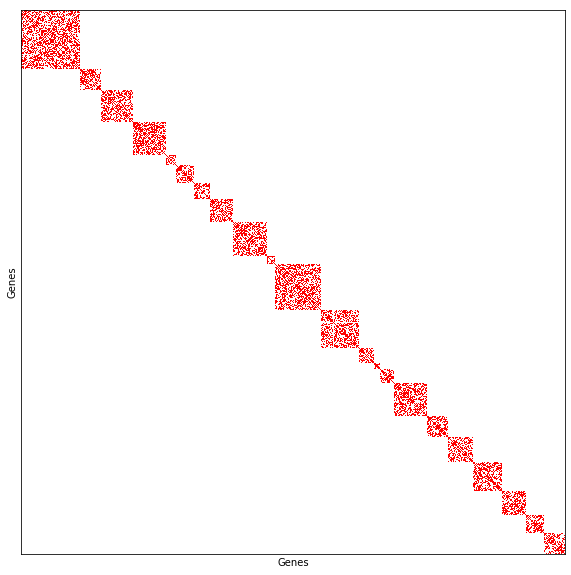

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(
    gene_corrs_df.loc[genes_order, genes_order].values, vmin=-0.05, vmax=0.05, cmap=cmap
)
ax.set_xlabel("Genes")
ax.set_ylabel("Genes")
ax.set_xticks([])
ax.set_yticks([])

# Testing

In [50]:
# COL4A1 and COL4A2
gene1 = "ENSG00000187498"
gene2 = "ENSG00000134871"

gene_corrs_df.loc[gene1, gene2]

0.20567855

In [51]:
_genes_files = all_gene_corr_files_df[all_gene_corr_files_df["chromosome"] == 13][
    "corr_file"
].tolist()
assert len(_genes_files) == 49

In [52]:
_gene_values = []
for f in _genes_files:
    gene1_gene2_corr = pd.read_pickle(f).loc[gene1, gene2]
    _gene_values.append(gene1_gene2_corr)

In [53]:
_gene_values = np.array(_gene_values)
assert _gene_values.shape[0] == 49

In [54]:
display(_gene_values.mean())
display(pd.Series(_gene_values).describe())
assert gene_corrs_df.loc[gene1, gene2].round(5) == _gene_values.mean().round(
    5
), gene_corrs_df.loc[gene1, gene2]

0.20567855

count    49.000000
mean      0.205679
std       0.376234
min      -0.018678
25%       0.000000
50%       0.000000
75%       0.090196
max       0.968930
dtype: float64

# Save

## With ensemble ids

In [55]:
output_file_name_template = conf.PHENOMEXCAN["LD_BLOCKS"][
    "GENE_CORRS_FILE_NAME_TEMPLATES"
]["GENE_CORR_AVG"]

output_file = OUTPUT_DIR_BASE / output_file_name_template.format(
    prefix="",
    suffix="gene_ensembl_ids",
)
display(output_file)

PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/gtex_v8/mashr/multiplier_genes-pred_expression_corr_avggene_ensembl_ids.pkl')

In [56]:
gene_corrs_df.to_pickle(output_file)

## With gene symbols

In [57]:
output_file_name_template = conf.PHENOMEXCAN["LD_BLOCKS"][
    "GENE_CORRS_FILE_NAME_TEMPLATES"
]["GENE_CORR_AVG"]

output_file = OUTPUT_DIR_BASE / output_file_name_template.format(
    prefix="",
    suffix="gene_symbols",
)
display(output_file)

PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/gtex_v8/mashr/multiplier_genes-pred_expression_corr_avggene_symbols.pkl')

In [58]:
gene_corrs_gene_names_df = gene_corrs_df.rename(
    index=Gene.GENE_ID_TO_NAME_MAP, columns=Gene.GENE_ID_TO_NAME_MAP
)

In [59]:
assert gene_corrs_gene_names_df.index.is_unique

In [60]:
assert gene_corrs_gene_names_df.columns.is_unique

In [61]:
gene_corrs_gene_names_df.shape

(6452, 6452)

In [62]:
gene_corrs_gene_names_df.head()

id,GAS6,MMP14,DSP,MARCKSL1,SPARC,CTSD,EPAS1,PALLD,PHC2,LGALS3BP,...,LDHB,LDHC,ACAP2,ACAP3,CFL2,CFL1,NFIB,PLEKHG6,GNGT2,SERPINH1
id,,,,,,,,,,,,,,,,,,,,,
GAS6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
MMP14,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.002833,0.0,0.0,0.0,0.0,0.0
DSP,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
MARCKSL1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.003401,0.0,...,0.0,0.0,0.0,0.002546,0.000000,0.0,0.0,0.0,0.0,0.0
SPARC,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [63]:
gene_corrs_gene_names_df.to_pickle(output_file)